In [1]:
import os
import sys
import inspect 
import time
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import weierstrass as weier
from runs.runs_entropy import RRLoader,RRLoaderShuffled, Signal, Runs
import seaborn as sns
import statsmodels.api as sm

In [2]:
def resource_files():
    resource_dir = "tests/resources/rr"
    file_paths = []

    for root, dirs, files in os.walk(resource_dir):
        for file in files:
            file_paths.append(os.path.join(root, file))

    return file_paths

In [9]:
def get_entropy_df(signal_generator, num_samples, len_sample=None, resources=None, **kwargs):
    har, hdr, hno = [], [], []
    
    for idx in range(num_samples):
        if isinstance(signal_generator, type):  # if its class and not function then we need specific RRloader from core.runs.runs_entropy
            rr, annotations = signal_generator().load(resources[idx], 0, 1)
            signal = Signal(rr, annotations)
        else:  # It's a function
            signal_data = signal_generator(len_sample, **kwargs)
            annotations = np.zeros(len(signal_data))
            signal = Signal(signal_data, annotations=annotations)
        
        runs = Runs(signal)
        har.append(runs.HAR)
        hdr.append(runs.HDR)
        hno.append(runs.HNO)
    
    return pd.DataFrame(np.array([har, hdr, hno]).T, columns=['HAR', 'HDR', 'HNO'])

# Helper functions for signal generation
def weierstrass_jp(len_sample):
    return weier.asymmetric_weierstrass_jp(length=len_sample/2)

def weierstrass_sawtooth(len_sample, a=0.5, b=3):
    return weier.asymmetric_weierstrass_sawtooth(a, b, len_sample)

def ar_function(len_sample, phi=0.1, sigma=0.1, scale=3):
    return weier.autoregressive_function(len_sample, phi, sigma, scale)


def asymmetric_ar_function_jp(len_sample, phi=0.1, sigma=0.1, scale=3):
    return weier.asymmetric_autoregressive_jp(len_sample, phi, sigma, scale)

def normal_distribution(len_sample, mean=0, sigma=0.1, scale=3):
    std_dev = sigma * scale
    return np.random.normal(loc=mean, scale=std_dev, size=len_sample)

def chisquare_distribution(num_samples, df=2):
    signal = np.random.chisquare(df=df, size=num_samples)
    return signal


def statistical_tests(group1, group2):
    stat1, p1 = stats.shapiro(group1)
    stat2, p2 = stats.shapiro(group2)
    if 0.05 <= p1 and 0.05 <= p2:
        #print("Performing T-test for independent groups")
        return stats.ttest_ind(group1, group2)
    else:
        #print("Performing Mann-Whitney test")
        return stats.mannwhitneyu(group1, group2)

def bootstrap_p_values(group1, group2, func, n_iterations=100, resources=None, num_samples=None, len_sample=None, **kwargs):
    p_values = []
    for _ in range(n_iterations):
        # Get default arguments for the function or class
        default_args = {
            k: v.default
            for k, v in inspect.signature(func.__init__ if isinstance(func, type) else func).parameters.items()
            if v.default is not inspect.Parameter.empty
        }
        # Update with any provided kwargs
        default_args.update(kwargs)
        
        # Generate new shuffled group using the provided function or class
        if isinstance(func, type):  # If func is a class
            if resources is None:
                raise ValueError("Resources must be provided when func is a class")
            shuffled_group2 = get_entropy_df(func, num_samples=len(group2), resources=resources, **default_args)
        else:  # If func is a function
            shuffled_group2 = get_entropy_df(func, num_samples=len(group2), len_sample=len_sample, **default_args)
        
        # Perform statistical test
        _, p_value = statistical_tests(group1, shuffled_group2[group2.name])
        p_values.append(p_value)
    return p_values


In [10]:
def full_analysis(df1, df2, df1_label, df2_label, signal_func, resources=None, n_iterations=100, num_samples=None, len_sample=None):
    """
    Comprehensive Statistical Analysis of Entropy Data from diffrent sources, organic and synthetic

    This script performs a detailed statistical analysis and visualization of entropy data
    derived from RR intervals, comparing df1 and df2 of the data.

    Key Components:

    1. Data Preparation:
       - Loads non-shuffled entropy data from RR intervals
       - Generatesentropy data for comparison

    2. Visualization:
       - Creates a 3x3 grid of plots for each entropy measure (HAR, HDR, HNO):
         a) Histograms with KDE for both non-shuffled and shuffled data
         b) Q-Q plots for assessing normality of both datasets
         c) Boxplots for comparing distributions and identifying outliers

    3. Statistical Analyses:
       a) Correlation Analysis:
          - Computes and displays correlation matrices for both datasets
       b) Variation Analysis:
          - Calculates and shows variance for each variable in both datasets
       c) Normality and Comparison Tests:
          - Performs Shapiro-Wilk test for normality
          - Conducts either t-test (for normal data) or Mann-Whitney U test (for non-normal data)
       d) Bootstrap Analysis:
          - Performs bootstrap resampling to estimate the stability of p-values
       e) Effect Size Calculation:
          - Computes Cohen's d for each variable to quantify the magnitude of differences
       f) Distribution Comparison:
          - Applies Kolmogorov-Smirnov test to compare overall distributions

    Functions:
    - statistical_tests(group1, group2): 
        Performs appropriate statistical test based on normality of data
    - bootstrap_p_values(group1, group2, n_iterations=1000): 
        Conducts bootstrap analysis of p-values

    Usage:
    Run this script to generate a comprehensive statistical report and visualization
    of the entropy data from RR intervals. The script will display plots and print
    various statistical measures and test results to the console.

    Requirements:
    - Python libraries: numpy, pandas, matplotlib, seaborn, scipy, statsmodels
    - Custom functions: resource_files(), get_entropty_from_rr(), get_entropty_from_shufled_rr()

    Note: Ensure that the required data files and custom functions are available in the
    same directory or properly imported before running this script.
    """
    columns = ["HAR", "HDR", "HNO"]
    # Histograms and Boxplots
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 25))

    for i, column in enumerate(columns):
        # Histogram
        sns.histplot(df1[column], label=df1_label, ax=axes[0, i], kde=True, color='blue' )
        sns.histplot(df2[column], label=df2_label, ax=axes[0, i], kde=True, color='orange')
        axes[0, i].set_xlabel(column)
        axes[0, i].set_title(f"Histogram of {column}")
        axes[0, i].legend()


        # Boxplot
        data_to_plot = [df1[column], df2[column]]
        axes[1, i].boxplot(data_to_plot, labels=[df1_label, df2_label])
        axes[1, i].set_title(f"Boxplot of {column}")
        axes[1, i].set_ylabel(column)

    plt.suptitle(f"Histogram, and Boxplots of Entropy for {df1_label} and {df2_label}")
    #plt.tight_layout()
    plt.show()

    # Correlation analysis
    print(f"Correlation analysis for {df1_label} data:")
    print(df1.corr())
    print(f"\nCorrelation analysis for {df2_label} data:")
    print(df2.corr())

    # Variation analysis
    print(f"\nVariation analysis for {df1_label} data:")
    print(df1.var())
    print(f"\nVariation analysis for {df2_label} data:")
    print(df2.var())

    # Statistical tests and bootstrap
    for column in columns:
        print(f"\nStatistical tests for {column}:")
        stat_result = statistical_tests(df1[column], df2[column])
        print(stat_result)

        print(f"\nBootstrap p-values for {column}:")
        p_values = bootstrap_p_values(df1[column], df2[column], signal_func, resources=resources, n_iterations=n_iterations,num_samples=num_samples, len_sample=len_sample)
        print(f"Mean p-value: {np.mean(p_values)}")
        print(f"95% CI: ({np.percentile(p_values, 2.5)}, {np.percentile(p_values, 97.5)})")

    # Additional statistical analysis: Effect size (Cohen's d)
    for column in columns:
        effect_size = (df1[column].mean() - df2[column].mean()) / \
                      np.sqrt((df1[column].var() + df2[column].var()) / 2)
        print(f"\nCohen's d effect size for {column}: {effect_size}")

    # Kolmogorov-Smirnov test for distribution comparison
    for column in columns:
        ks_stat, ks_p = stats.ks_2samp(df1[column], df2[column])
        print(f"\nKolmogorov-Smirnov test for {column}:")
        print(f"Statistic: {ks_stat}, p-value: {ks_p}")



Analyzing Shuffled RR vs Non-shuffled RR


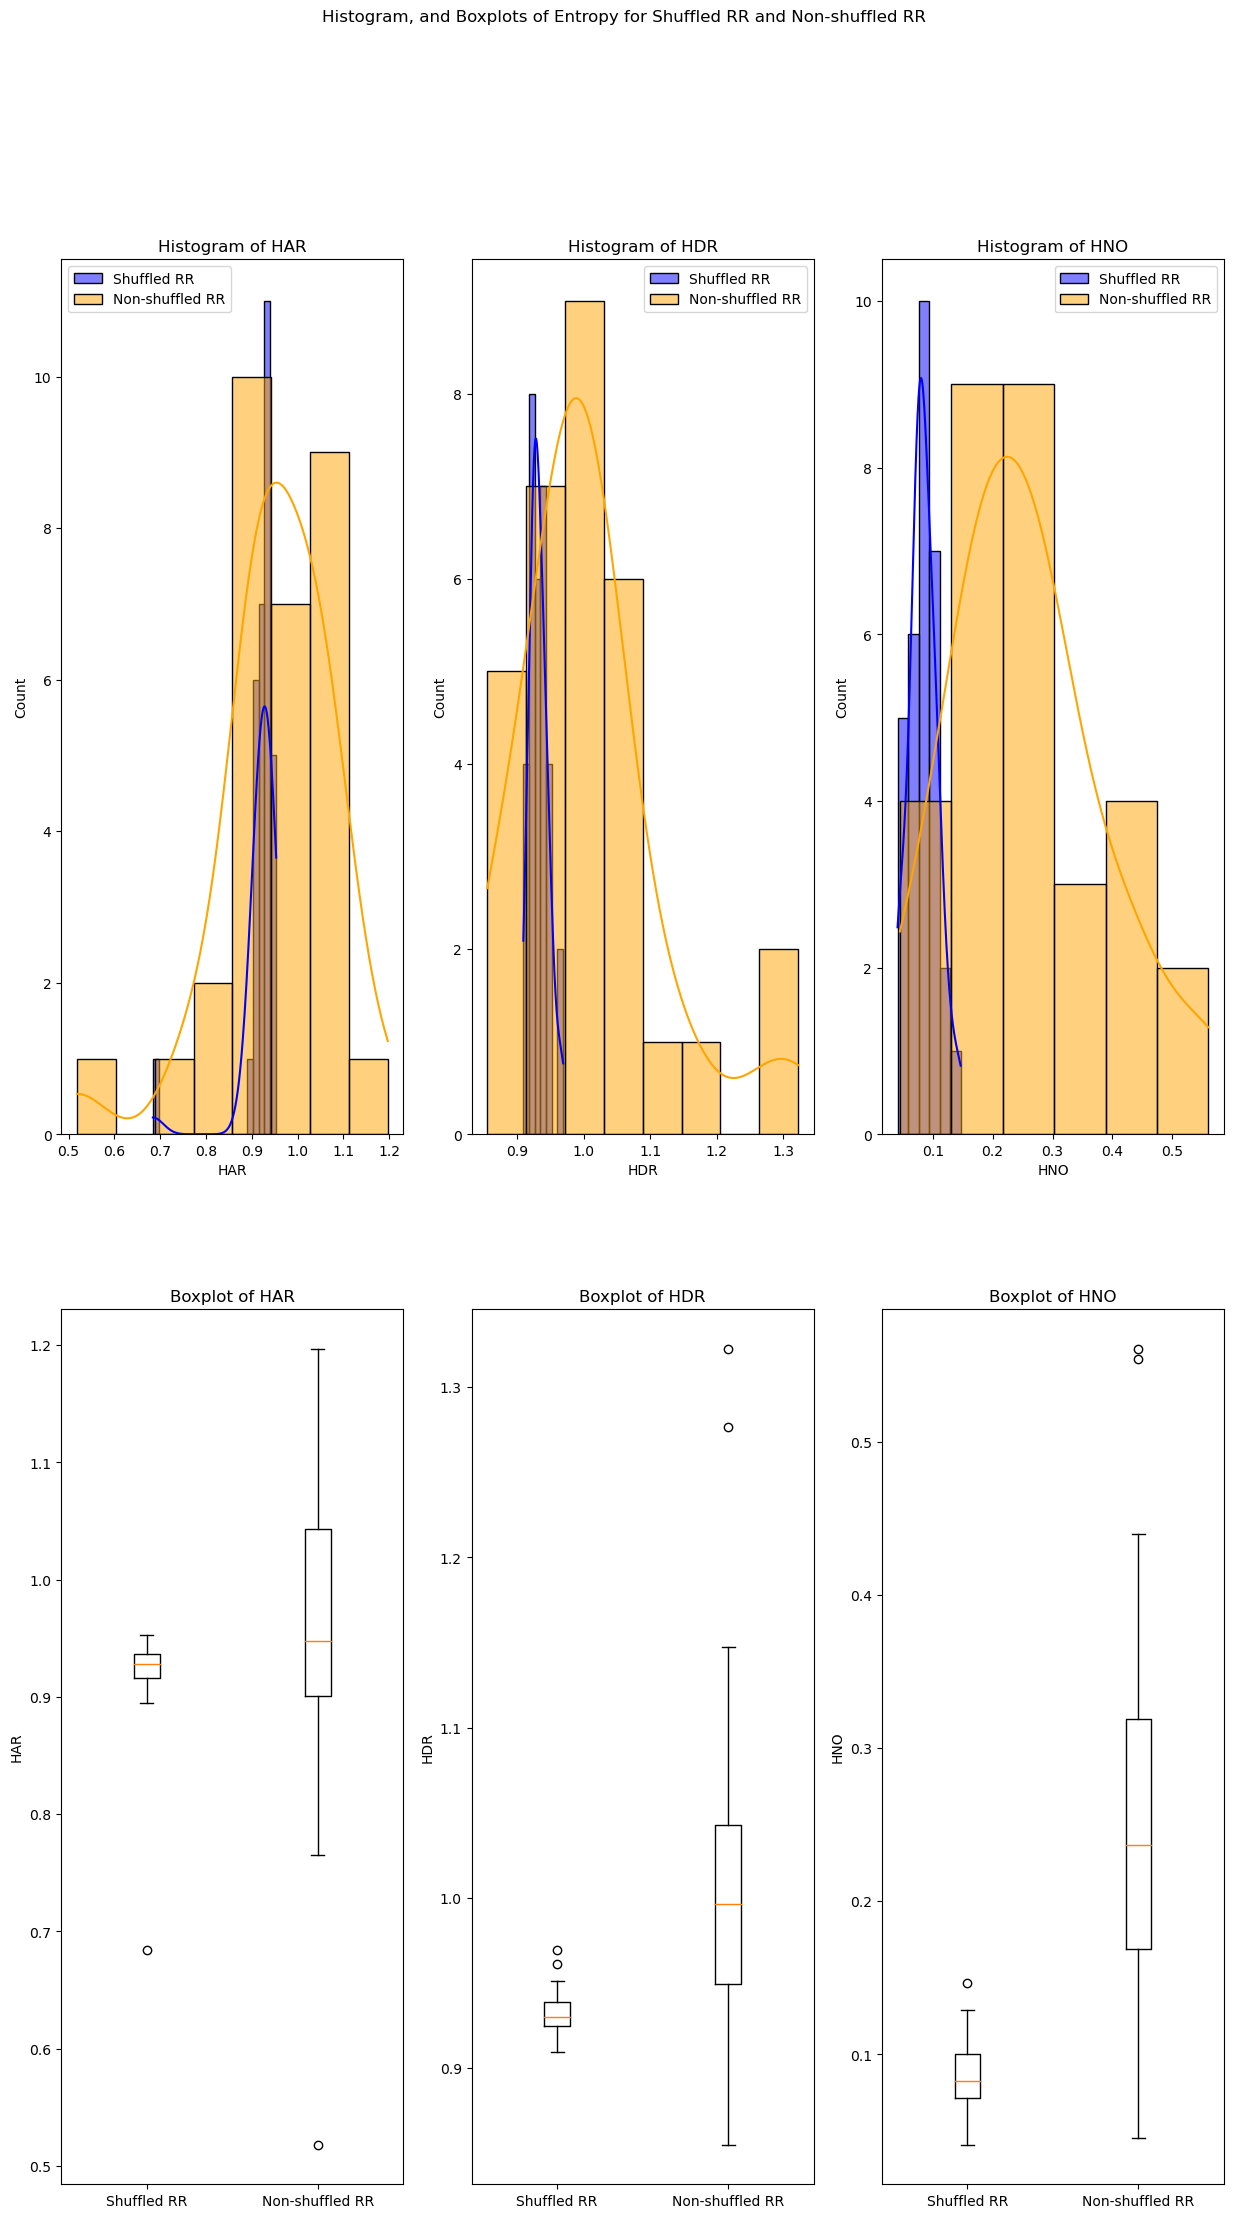

Correlation analysis for Shuffled RR data:
          HAR       HDR       HNO
HAR  1.000000 -0.315062 -0.017242
HDR -0.315062  1.000000 -0.737801
HNO -0.017242 -0.737801  1.000000

Correlation analysis for Non-shuffled RR data:
          HAR       HDR       HNO
HAR  1.000000  0.297938  0.324511
HDR  0.297938  1.000000  0.001671
HNO  0.324511  0.001671  1.000000

Variation analysis for Shuffled RR data:
HAR    0.002106
HDR    0.000188
HNO    0.000585
dtype: float64

Variation analysis for Non-shuffled RR data:
HAR    0.015860
HDR    0.011012
HNO    0.016701
dtype: float64

Statistical tests for HAR:
MannwhitneyuResult(statistic=354.0, pvalue=0.07607964825064255)

Bootstrap p-values for HAR:
Mean p-value: 0.07607964825064253
95% CI: (0.07607964825064255, 0.07607964825064255)

Statistical tests for HDR:
MannwhitneyuResult(statistic=184.0, pvalue=3.082858180591898e-05)

Bootstrap p-values for HDR:
Mean p-value: 3.0828581805918984e-05
95% CI: (3.082858180591898e-05, 3.082858180591898e-05)

S

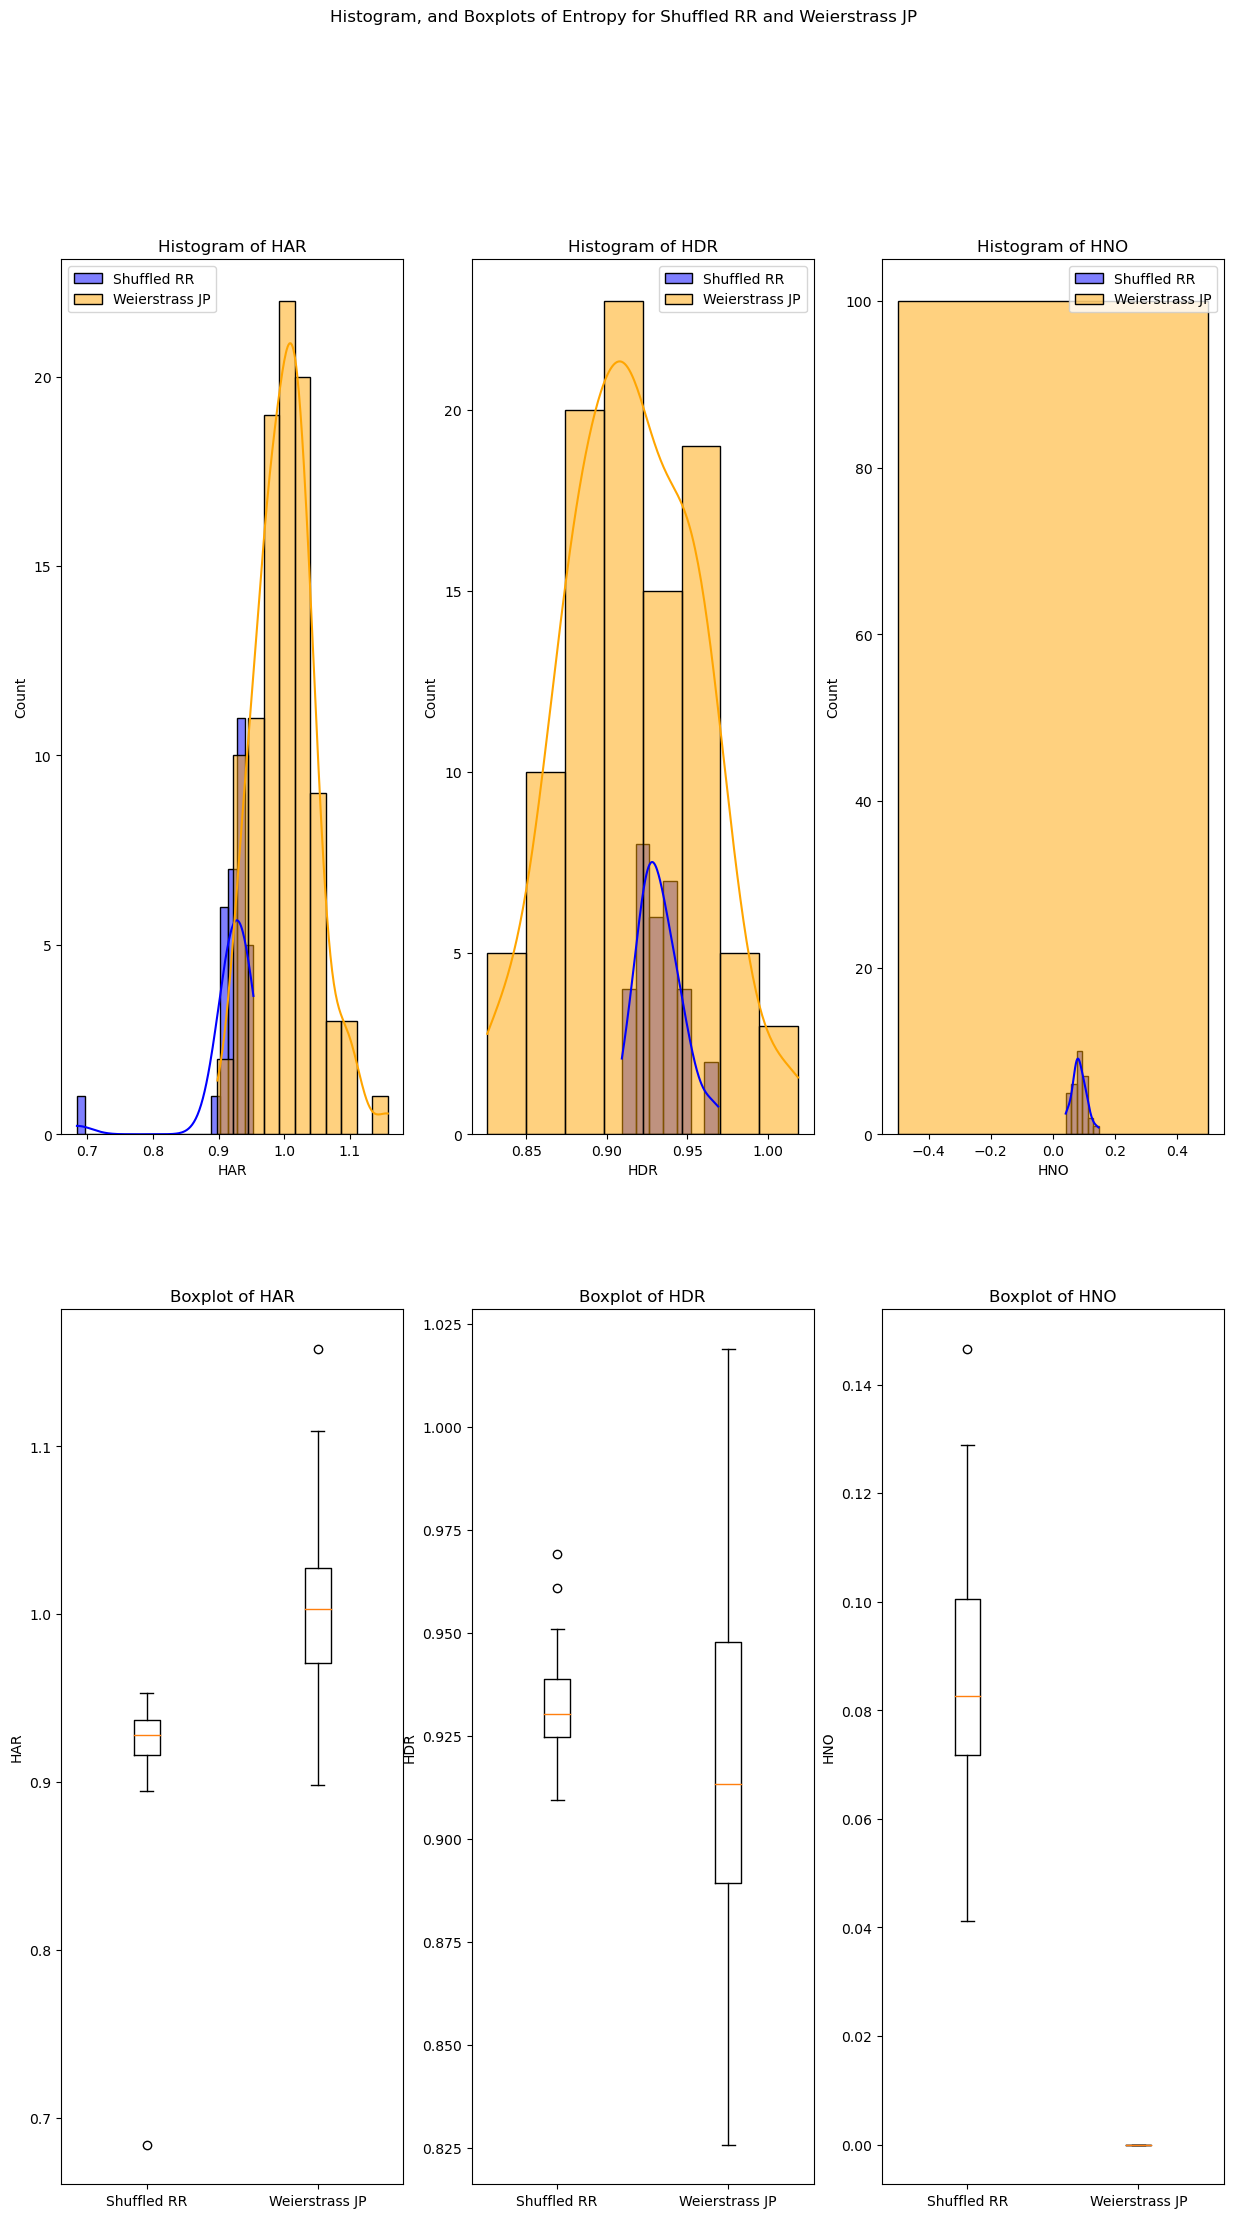

Correlation analysis for Shuffled RR data:
          HAR       HDR       HNO
HAR  1.000000 -0.315062 -0.017242
HDR -0.315062  1.000000 -0.737801
HNO -0.017242 -0.737801  1.000000

Correlation analysis for Weierstrass JP data:
          HAR       HDR  HNO
HAR  1.000000 -0.486188  NaN
HDR -0.486188  1.000000  NaN
HNO       NaN       NaN  NaN

Variation analysis for Shuffled RR data:
HAR    0.002106
HDR    0.000188
HNO    0.000585
dtype: float64

Variation analysis for Weierstrass JP data:
HAR    0.002001
HDR    0.001623
HNO    0.000000
dtype: float64

Statistical tests for HAR:
MannwhitneyuResult(statistic=135.0, pvalue=1.8600989193287074e-14)

Bootstrap p-values for HAR:
Mean p-value: 1.907834712921188e-12
95% CI: (1.833209593060589e-15, 1.131994147741503e-11)

Statistical tests for HDR:
Ttest_indResult(statistic=2.2878569051304725, pvalue=0.02377322055830867)

Bootstrap p-values for HDR:
Mean p-value: 0.09307656831739111
95% CI: (0.0031042248149903374, 0.3897953044085322)

Statistical 

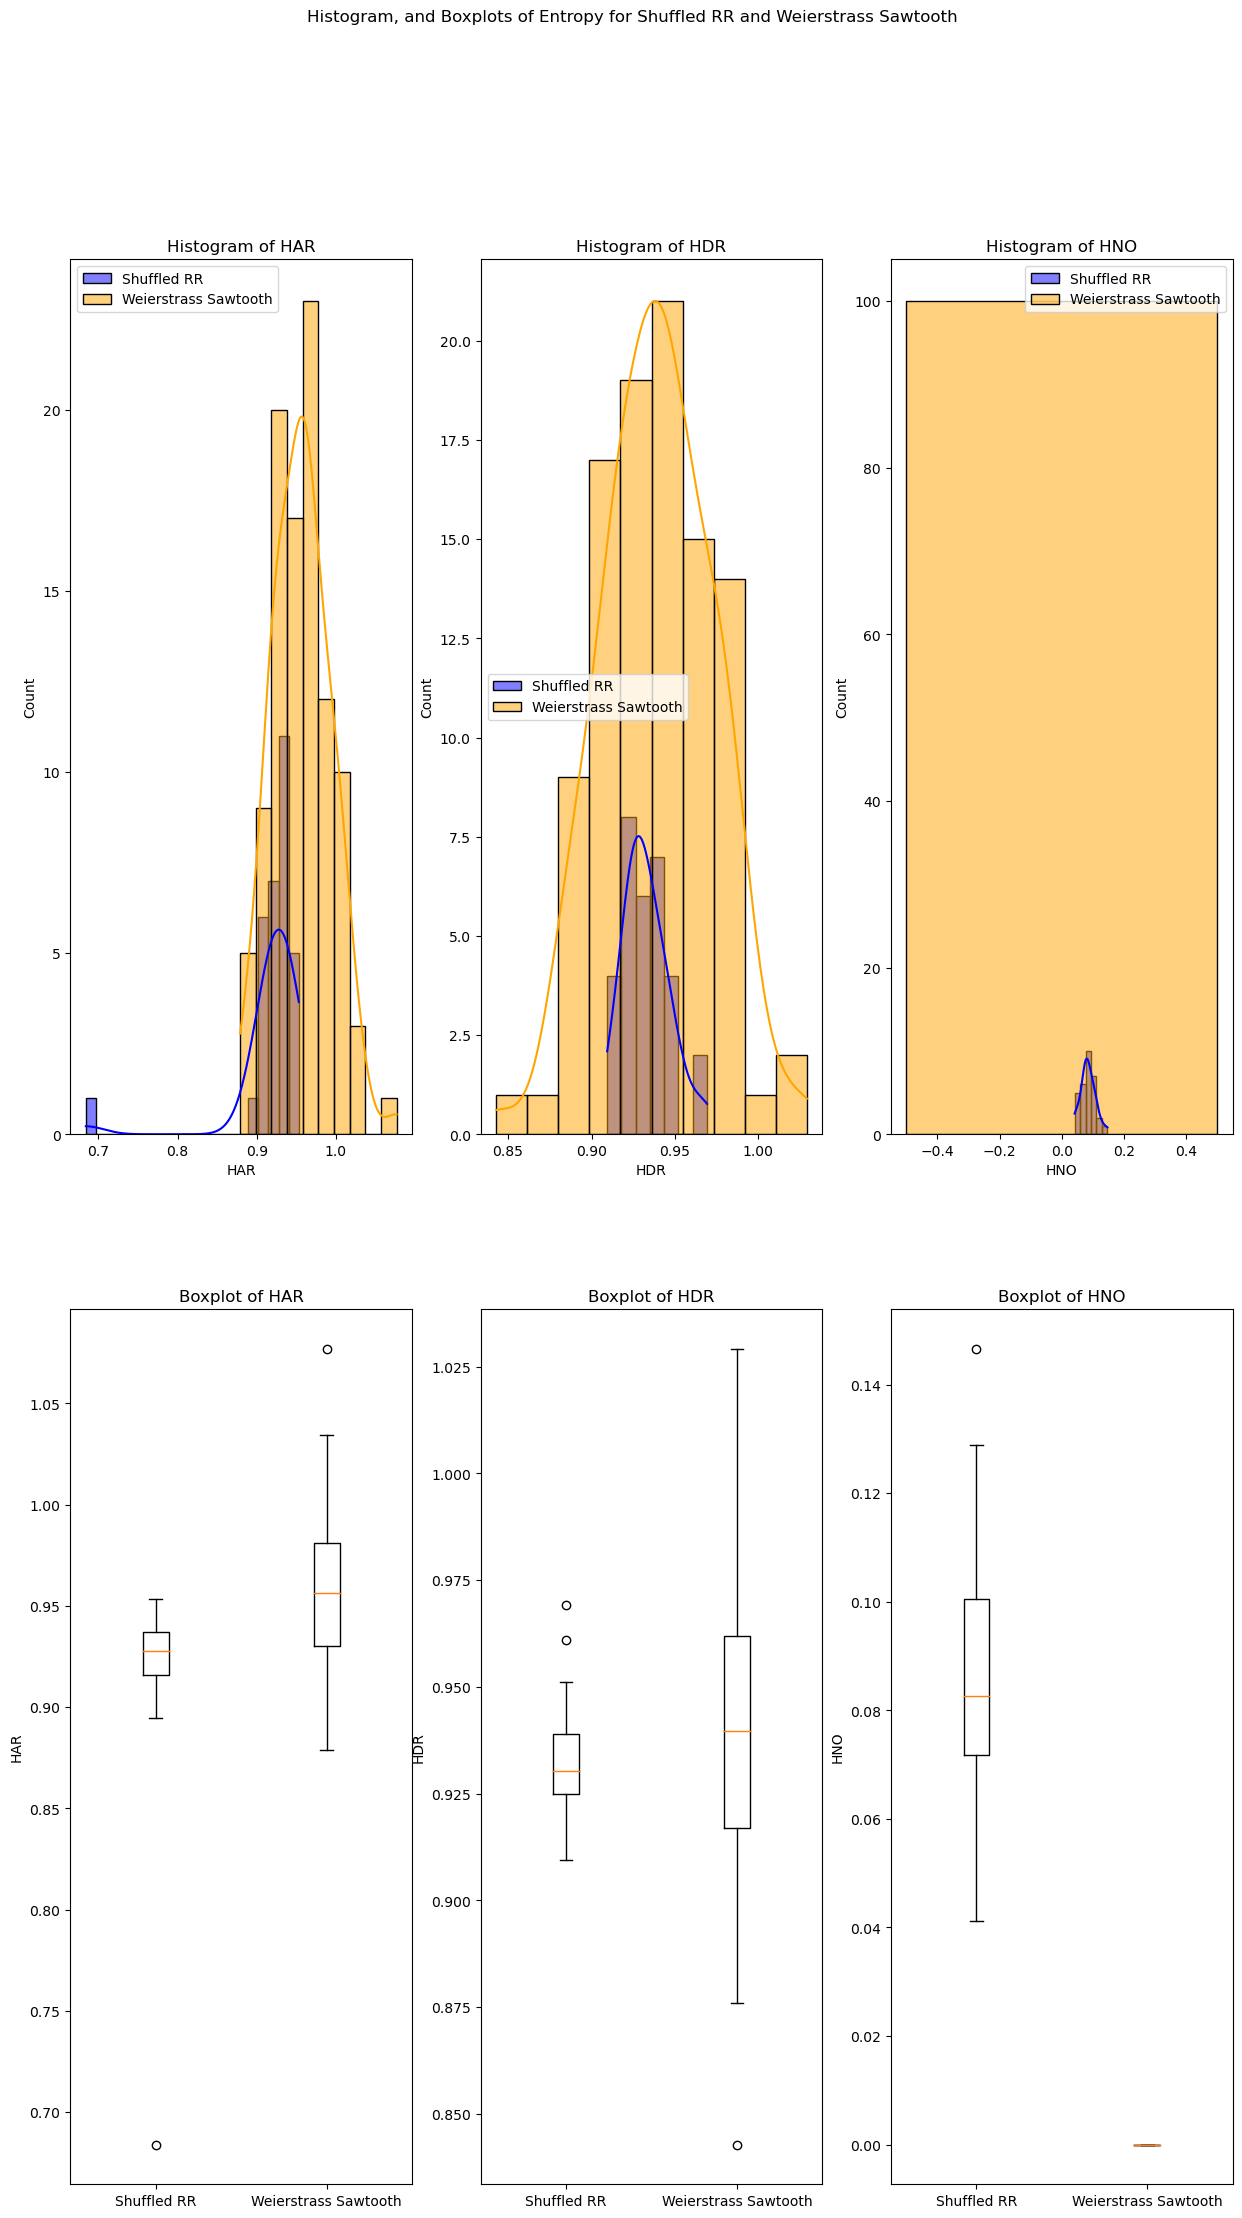

Correlation analysis for Shuffled RR data:
          HAR       HDR       HNO
HAR  1.000000 -0.315062 -0.017242
HDR -0.315062  1.000000 -0.737801
HNO -0.017242 -0.737801  1.000000

Correlation analysis for Weierstrass Sawtooth data:
          HAR       HDR  HNO
HAR  1.000000 -0.340196  NaN
HDR -0.340196  1.000000  NaN
HNO       NaN       NaN  NaN

Variation analysis for Shuffled RR data:
HAR    0.002106
HDR    0.000188
HNO    0.000585
dtype: float64

Variation analysis for Weierstrass Sawtooth data:
HAR    0.001356
HDR    0.001076
HNO    0.000000
dtype: float64

Statistical tests for HAR:
MannwhitneyuResult(statistic=708.0, pvalue=5.18948601222754e-06)

Bootstrap p-values for HAR:
Mean p-value: 9.951899225227086e-07
95% CI: (3.652128148666716e-10, 1.082837153193528e-05)

Statistical tests for HDR:
Ttest_indResult(statistic=-1.1037478183214604, pvalue=0.2717572082259597)

Bootstrap p-values for HDR:
Mean p-value: 0.3406681341677639
95% CI: (0.03301617851382341, 0.9671144242121188)

Stati

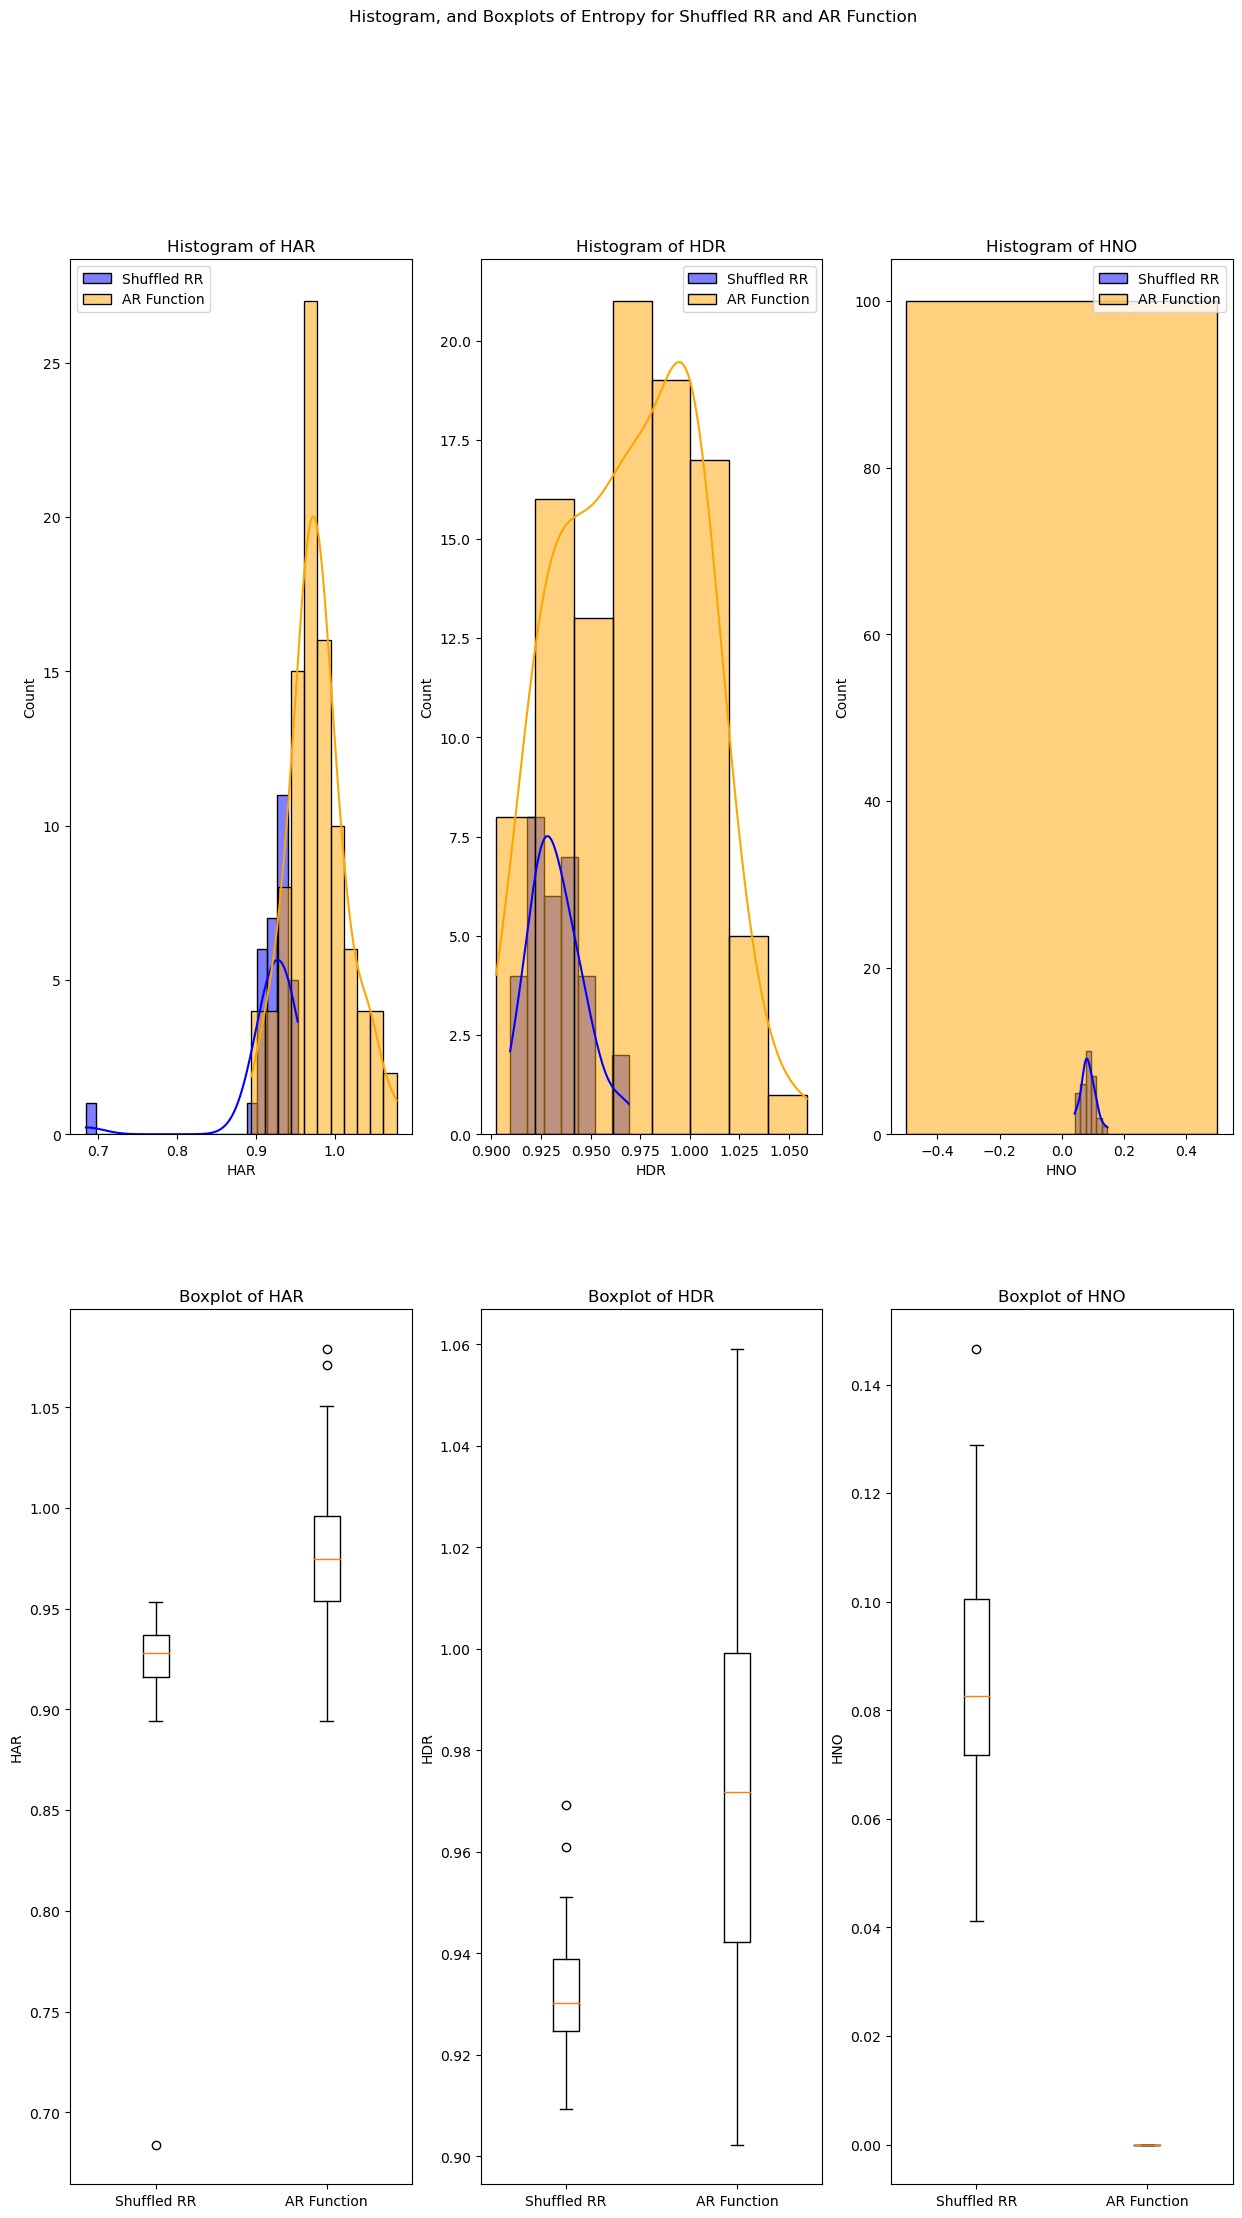

Correlation analysis for Shuffled RR data:
          HAR       HDR       HNO
HAR  1.000000 -0.315062 -0.017242
HDR -0.315062  1.000000 -0.737801
HNO -0.017242 -0.737801  1.000000

Correlation analysis for AR Function data:
          HAR       HDR  HNO
HAR  1.000000 -0.211455  NaN
HDR -0.211455  1.000000  NaN
HNO       NaN       NaN  NaN

Variation analysis for Shuffled RR data:
HAR    0.002106
HDR    0.000188
HNO    0.000585
dtype: float64

Variation analysis for AR Function data:
HAR    0.001316
HDR    0.001150
HNO    0.000000
dtype: float64

Statistical tests for HAR:
MannwhitneyuResult(statistic=273.0, pvalue=4.75732697399842e-12)

Bootstrap p-values for HAR:
Mean p-value: 2.709474628668035e-09
95% CI: (1.9377577622915792e-13, 2.0786991035911583e-08)

Statistical tests for HDR:
Ttest_indResult(statistic=-6.074129287104493, pvalue=1.3034753375849113e-08)

Bootstrap p-values for HDR:
Mean p-value: 5.935395563430652e-07
95% CI: (3.587896365990118e-11, 2.4187425904284648e-06)

Statistic

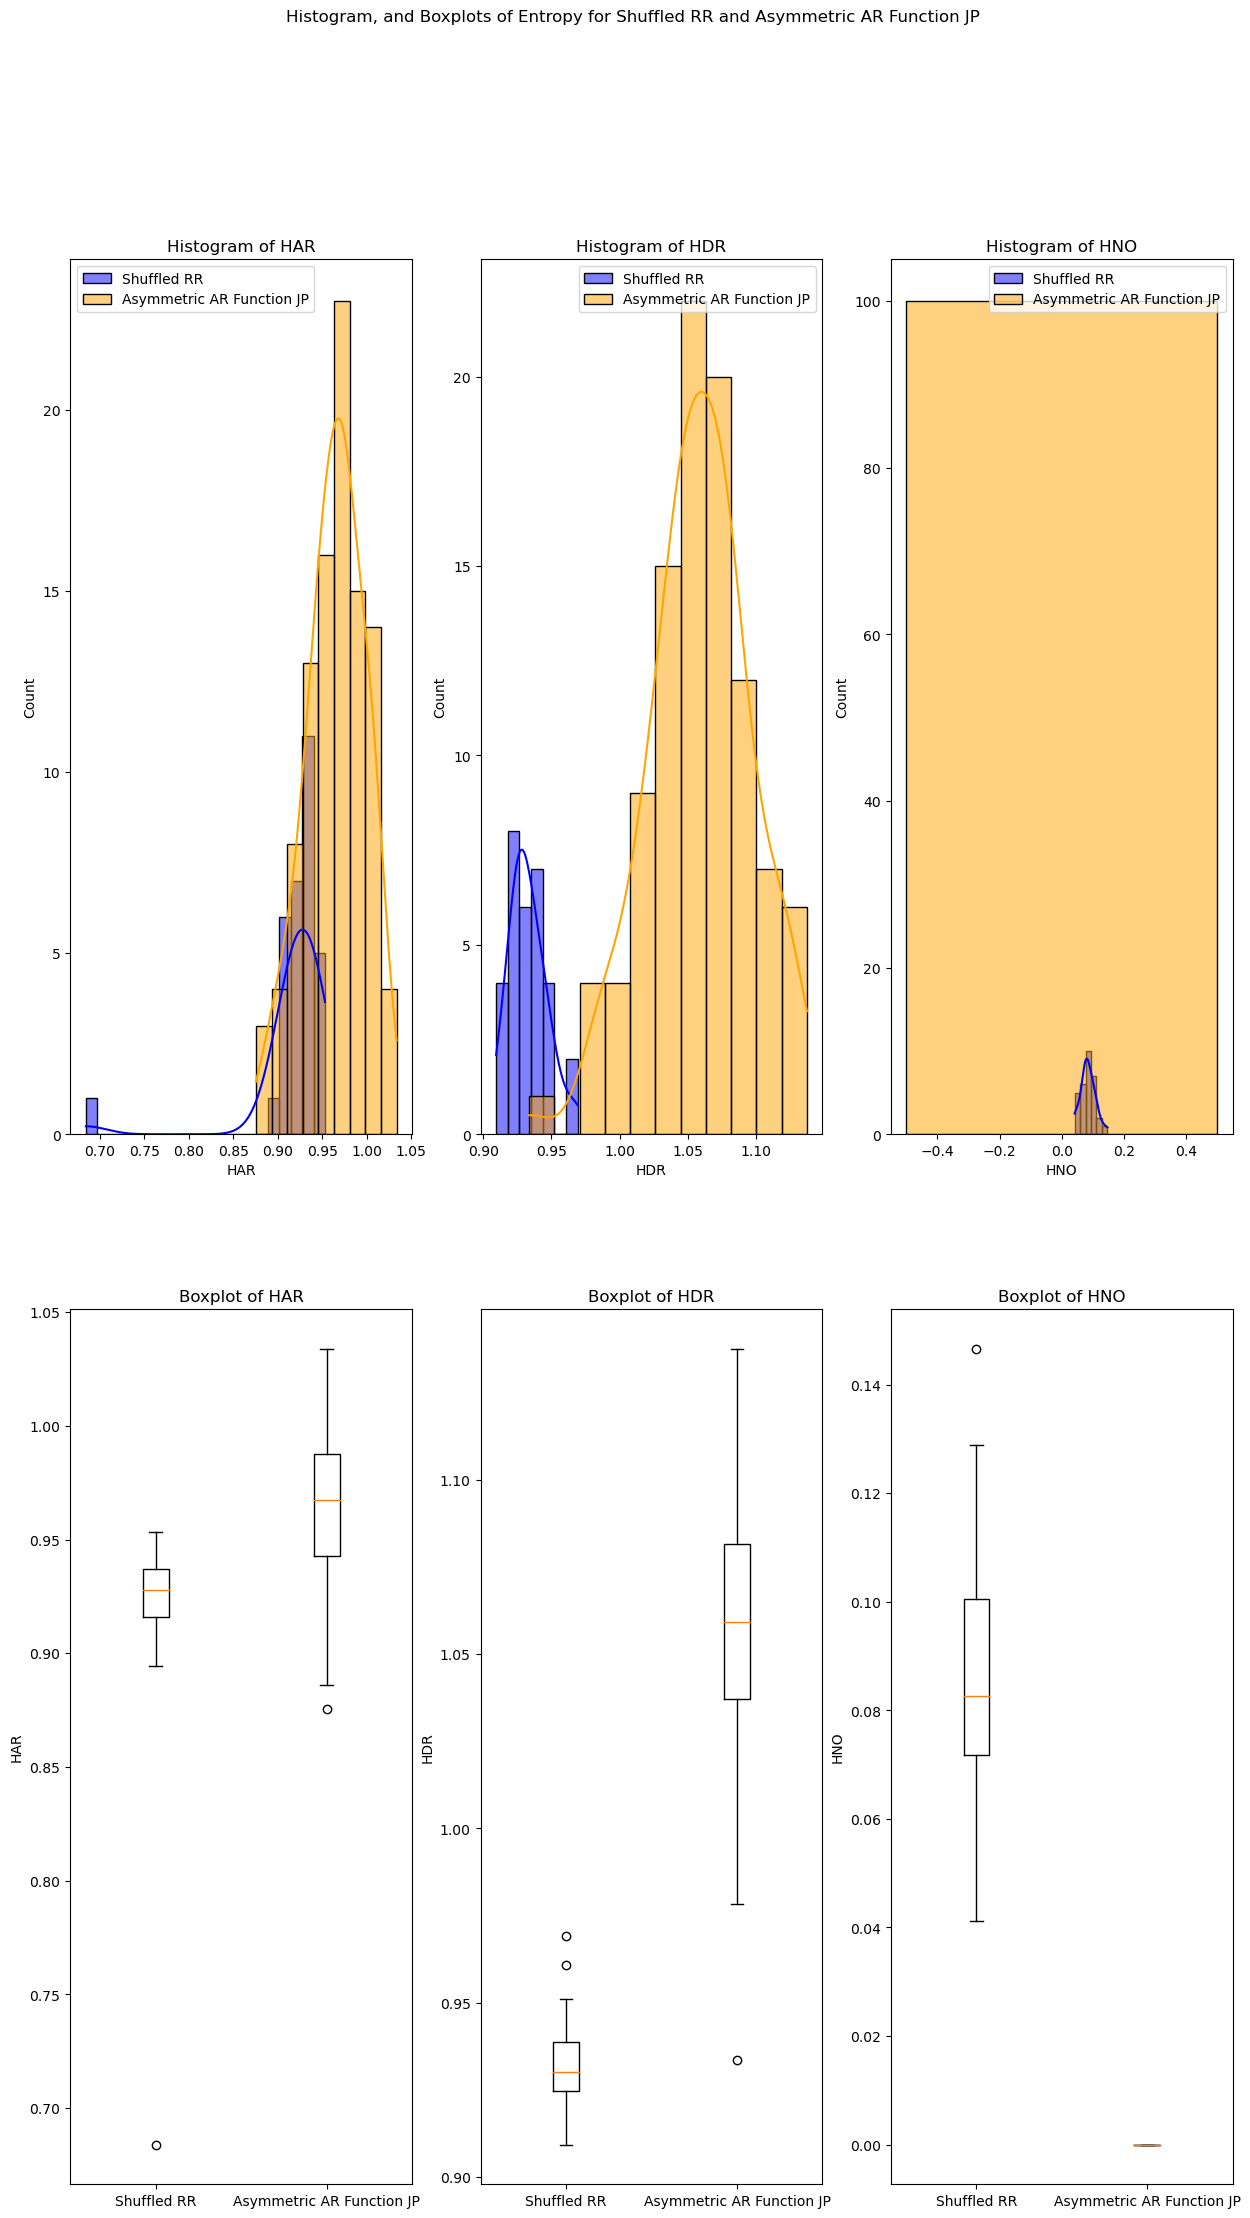

Correlation analysis for Shuffled RR data:
          HAR       HDR       HNO
HAR  1.000000 -0.315062 -0.017242
HDR -0.315062  1.000000 -0.737801
HNO -0.017242 -0.737801  1.000000

Correlation analysis for Asymmetric AR Function JP data:
          HAR       HDR  HNO
HAR  1.000000 -0.262003  NaN
HDR -0.262003  1.000000  NaN
HNO       NaN       NaN  NaN

Variation analysis for Shuffled RR data:
HAR    0.002106
HDR    0.000188
HNO    0.000585
dtype: float64

Variation analysis for Asymmetric AR Function JP data:
HAR    0.001113
HDR    0.001422
HNO    0.000000
dtype: float64

Statistical tests for HAR:
MannwhitneyuResult(statistic=462.0, pvalue=3.882041927778612e-09)

Bootstrap p-values for HAR:
Mean p-value: 9.757429667623051e-07
95% CI: (4.908102846949595e-10, 9.10092427070557e-06)

Statistical tests for HDR:
Ttest_indResult(statistic=-18.159343437368907, pvalue=2.3816126213924326e-37)

Bootstrap p-values for HDR:
Mean p-value: 4.2897855557514235e-18
95% CI: (2.1320876159014464e-44, 4.819

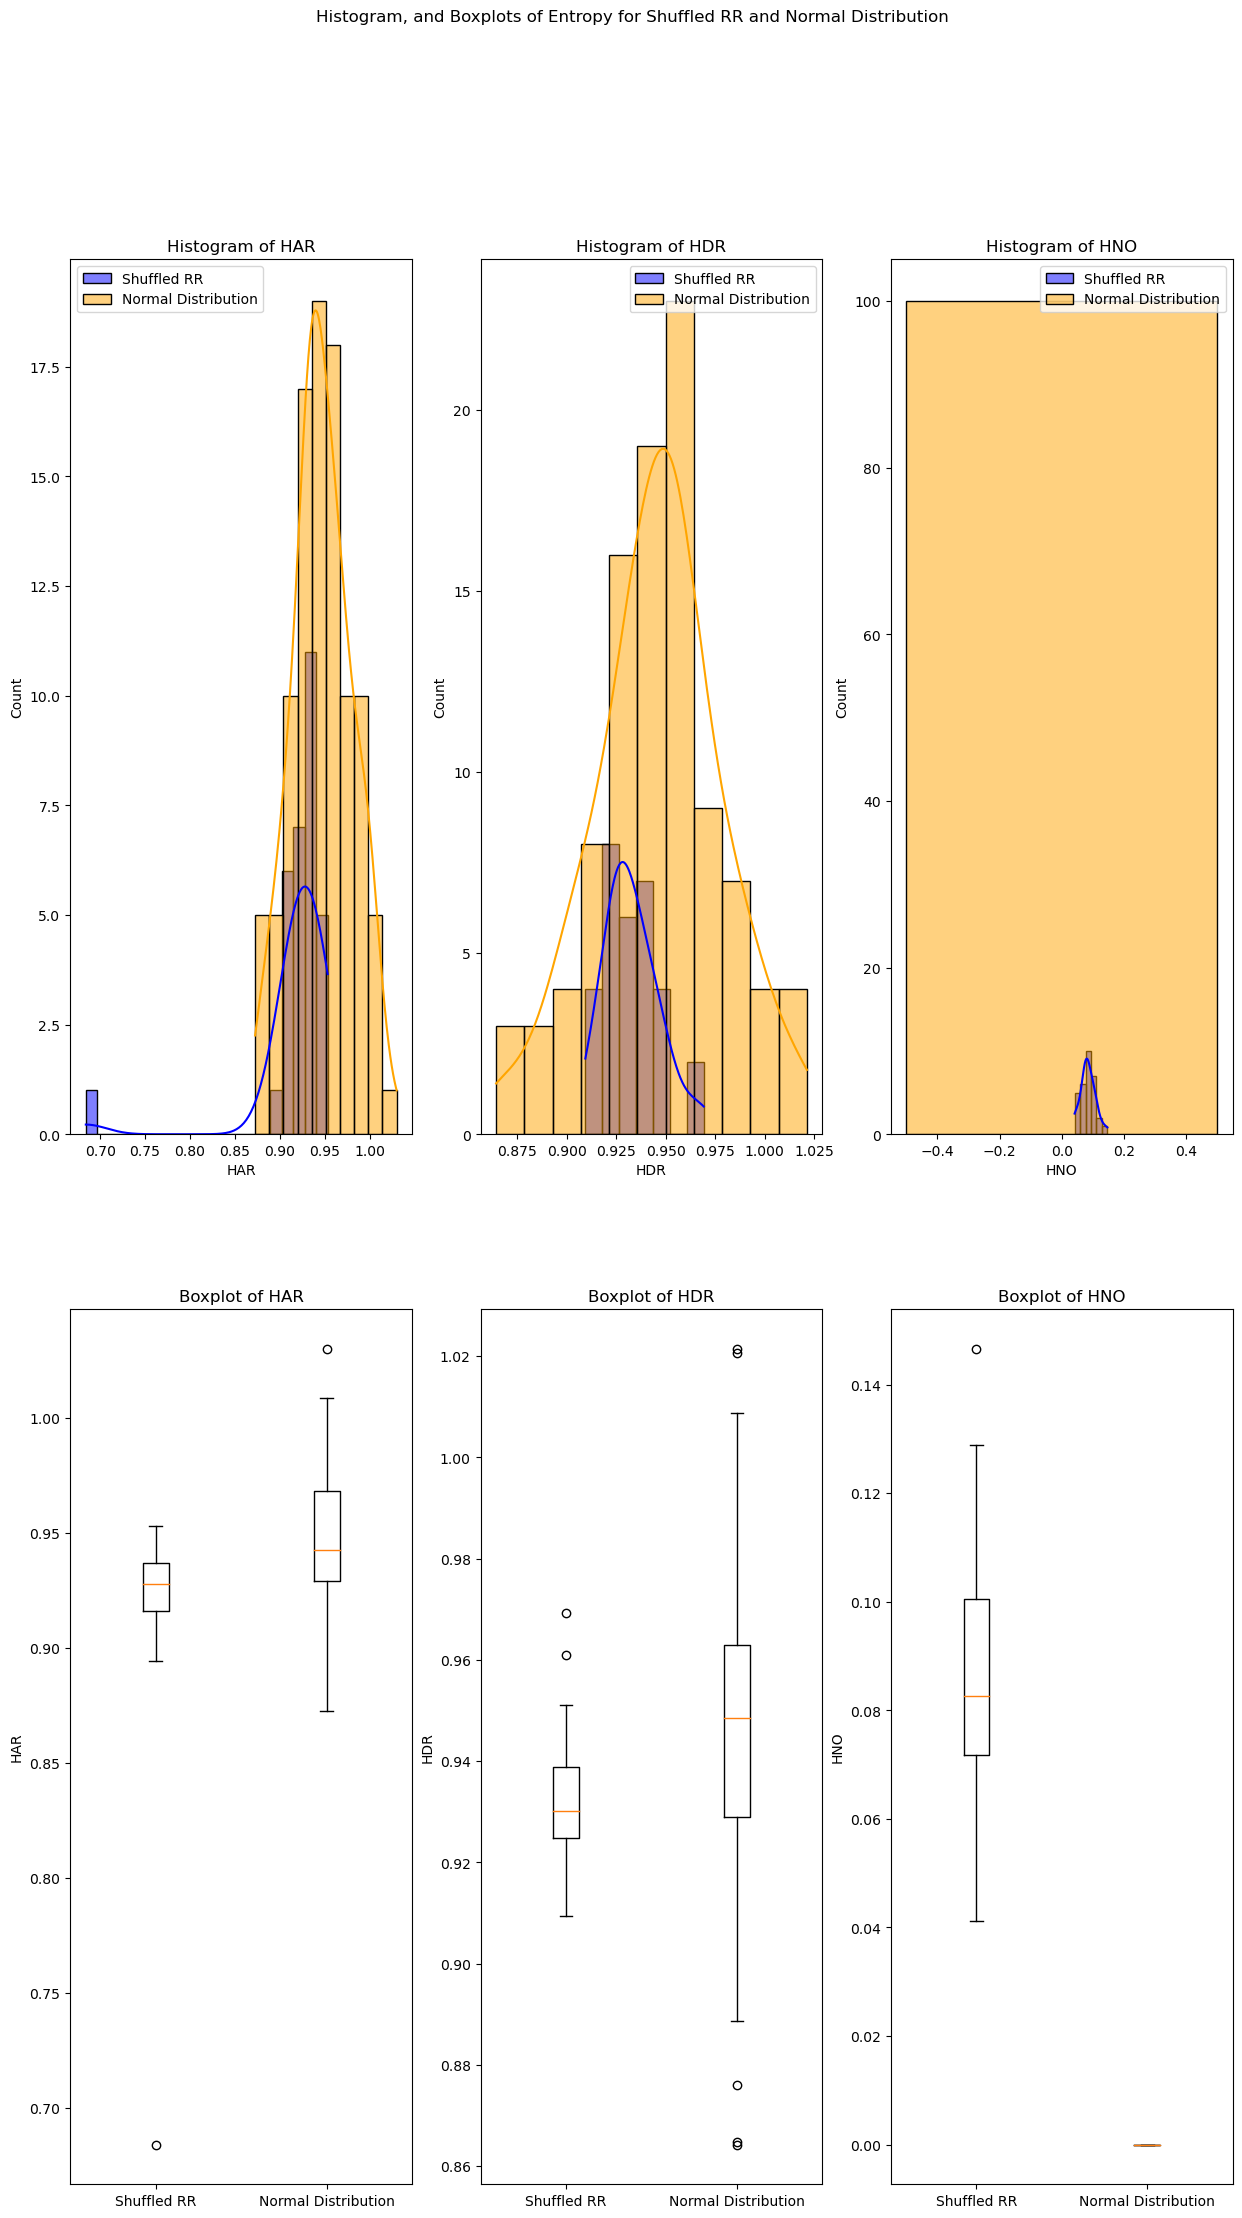

Correlation analysis for Shuffled RR data:
          HAR       HDR       HNO
HAR  1.000000 -0.315062 -0.017242
HDR -0.315062  1.000000 -0.737801
HNO -0.017242 -0.737801  1.000000

Correlation analysis for Normal Distribution data:
          HAR       HDR  HNO
HAR  1.000000 -0.171336  NaN
HDR -0.171336  1.000000  NaN
HNO       NaN       NaN  NaN

Variation analysis for Shuffled RR data:
HAR    0.002106
HDR    0.000188
HNO    0.000585
dtype: float64

Variation analysis for Normal Distribution data:
HAR    0.001078
HDR    0.001011
HNO    0.000000
dtype: float64

Statistical tests for HAR:
MannwhitneyuResult(statistic=882.0, pvalue=0.0003006780181394918)

Bootstrap p-values for HAR:
Mean p-value: 0.0004666124588512218
95% CI: (8.305706769791448e-07, 0.0020319206002905057)

Statistical tests for HDR:
Ttest_indResult(statistic=-2.263004097264998, pvalue=0.025306606504536876)

Bootstrap p-values for HDR:
Mean p-value: 0.014746123546445427
95% CI: (8.713195323262394e-05, 0.06953879868893385)



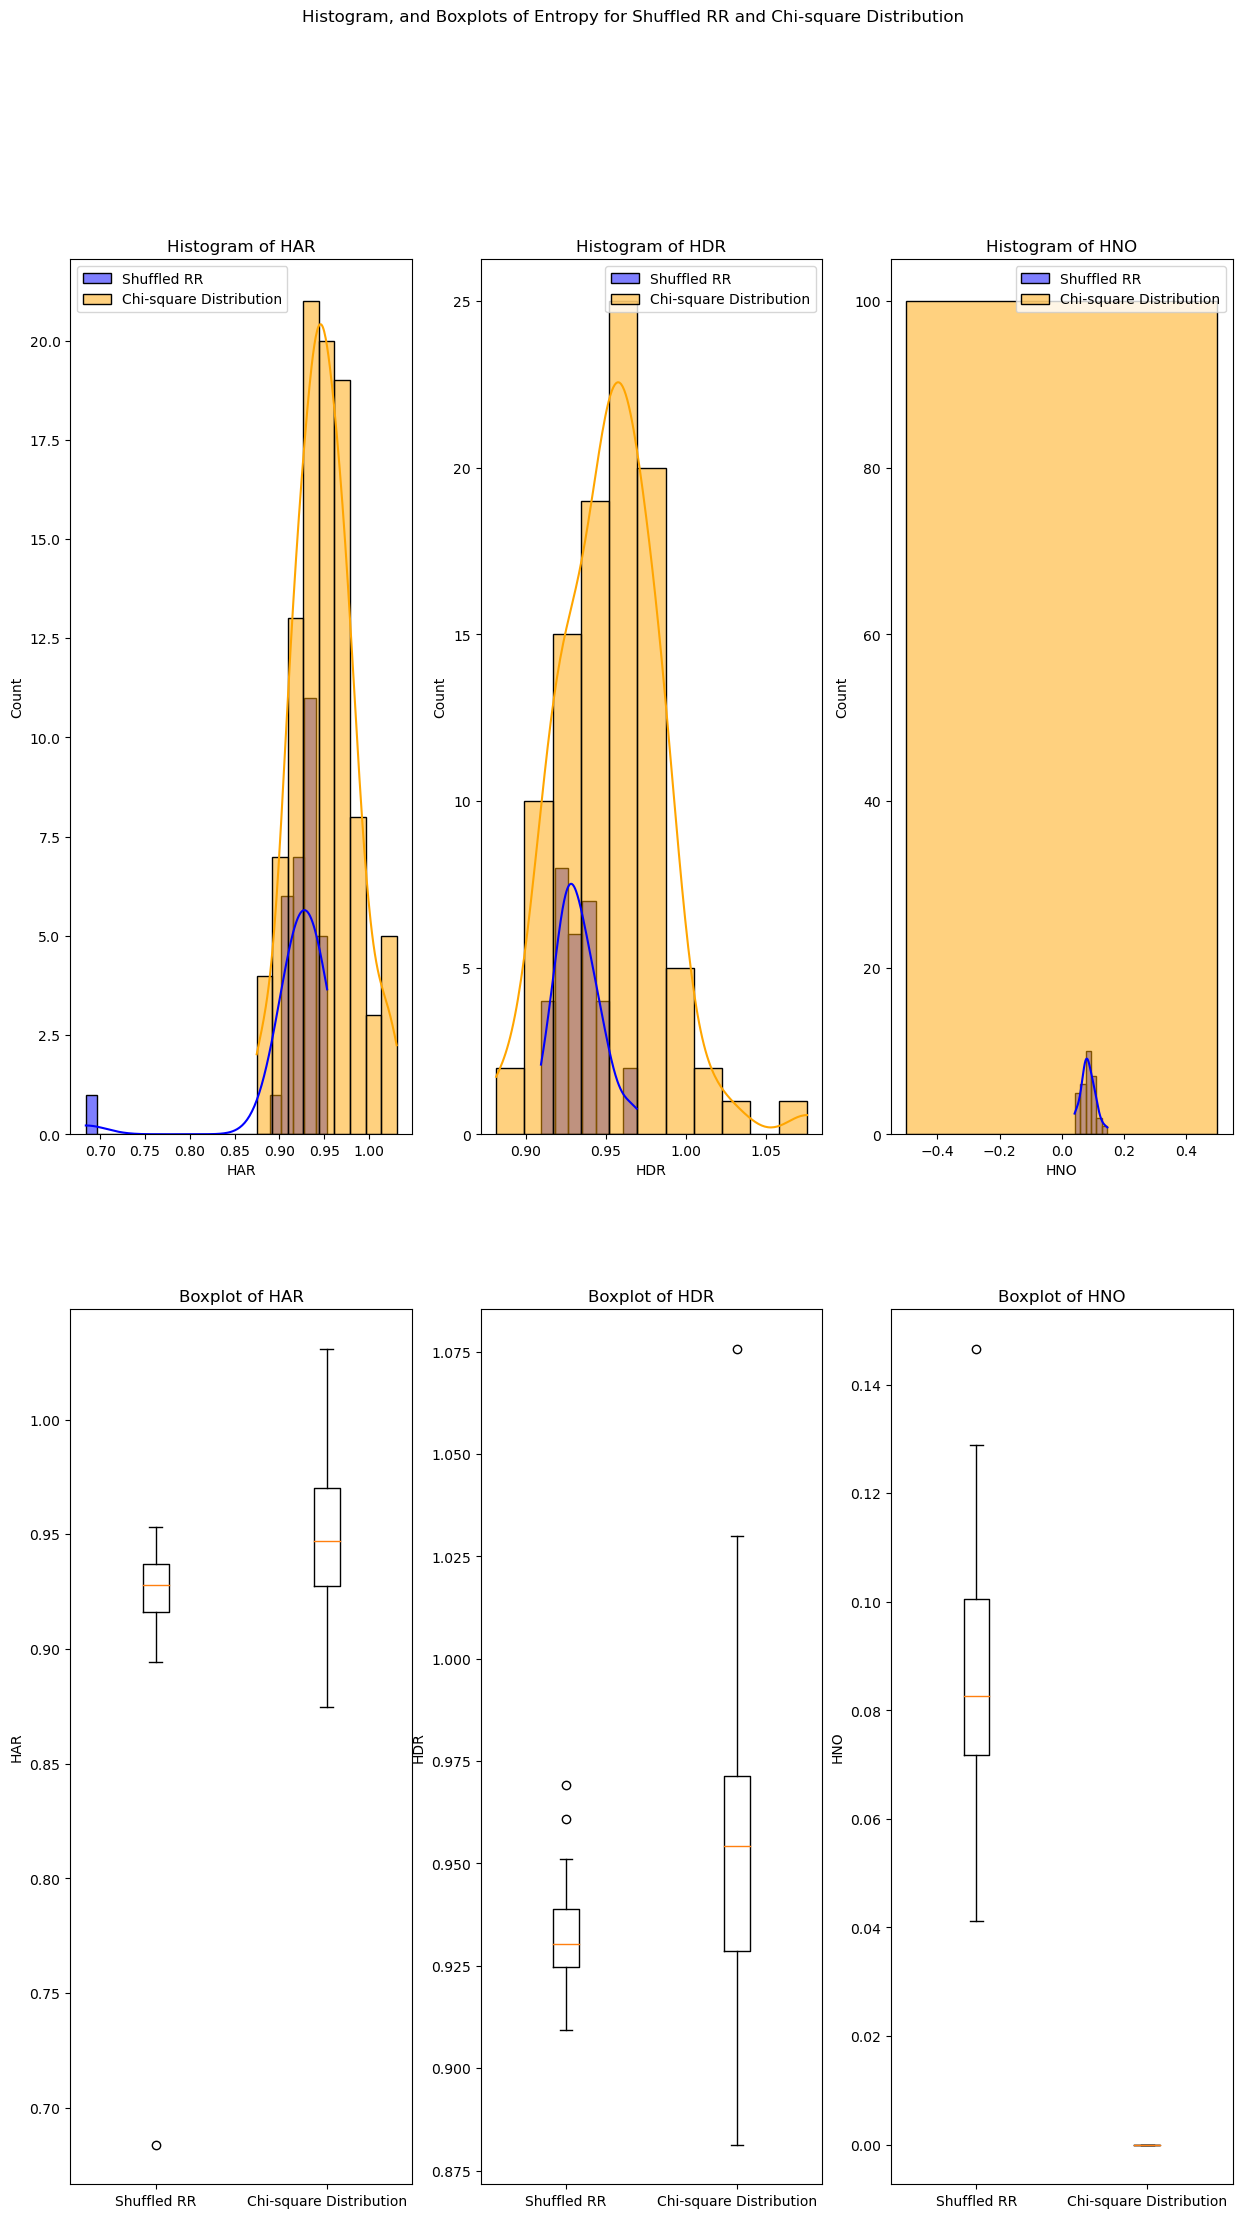

Correlation analysis for Shuffled RR data:
          HAR       HDR       HNO
HAR  1.000000 -0.315062 -0.017242
HDR -0.315062  1.000000 -0.737801
HNO -0.017242 -0.737801  1.000000

Correlation analysis for Chi-square Distribution data:
          HAR       HDR  HNO
HAR  1.000000 -0.113635  NaN
HDR -0.113635  1.000000  NaN
HNO       NaN       NaN  NaN

Variation analysis for Shuffled RR data:
HAR    0.002106
HDR    0.000188
HNO    0.000585
dtype: float64

Variation analysis for Chi-square Distribution data:
HAR    0.001055
HDR    0.000950
HNO    0.000000
dtype: float64

Statistical tests for HAR:
MannwhitneyuResult(statistic=825.0, pvalue=8.731255855234299e-05)

Bootstrap p-values for HAR:
Mean p-value: 0.0005791061521697716
95% CI: (2.489157195048183e-07, 0.005176749067228696)

Statistical tests for HDR:
MannwhitneyuResult(statistic=851.0, pvalue=0.00015520521451811904)

Bootstrap p-values for HDR:
Mean p-value: 0.015387055529738987
95% CI: (6.849205814483077e-05, 0.08629933683403027)

S

In [11]:
resources = resource_files()

import warnings
warnings.filterwarnings("ignore") # hide HNO warnings

# Create a list of tuples containing (dataframe, label, function/class, kwargs)
dataframes = [
    (get_entropy_df(RRLoaderShuffled, num_samples=len(resources), resources=resources), "Shuffled RR", RRLoaderShuffled, {"resources": resources}),
    (get_entropy_df(RRLoader, num_samples=len(resources), resources=resources), "Non-shuffled RR", RRLoader, {"resources": resources}),
    (get_entropy_df(weierstrass_jp, num_samples=100, len_sample=1000), "Weierstrass JP", weierstrass_jp, {}),
    (get_entropy_df(weierstrass_sawtooth, num_samples=100, len_sample=1000), "Weierstrass Sawtooth", weierstrass_sawtooth, {}),
    (get_entropy_df(ar_function, num_samples=100, len_sample=1000), "AR Function", ar_function, {}),
    (get_entropy_df(asymmetric_ar_function_jp, num_samples=100, len_sample=1000), "Asymmetric AR Function JP", asymmetric_ar_function_jp, {}),
    (get_entropy_df(normal_distribution, num_samples=100, len_sample=1000), "Normal Distribution", normal_distribution, {}),
    (get_entropy_df(chisquare_distribution, num_samples=100, len_sample=1000), "Chi-square Distribution", chisquare_distribution, {})
]

# Compare the first dataframe (Shuffled RR) against all others
df1, df1_label, func1, kwargs1 = dataframes[0]

for df2, df2_label, func2, kwargs2 in dataframes[1:]:
    print(f"\n\nAnalyzing {df1_label} vs {df2_label}")
    full_analysis(df1, df2, df1_label, df2_label, func2, 
                  resources=kwargs2.get('resources'), 
                  n_iterations=100, 
                  num_samples=100, 
                  len_sample=1000)

plt.show()